# Четвёртая версия.

 - Входные данные, пары: `BTC/USDT, ETH/USDT, BNB/USDT`,
 - Создание целевой функции по окну усреднения, с определением локальных максимумов и минимумов,
 - Устранены двойные сделки за один такт, оставлена сделка с наибольшим профитом,
 - Устранены подряд идущие одинаковые сделки в паре (выбраны сделки с максимумом для продажи и минимумом для покупки)
 - **для целевой функции максимумы и минимумы выставлены в верхние и нижние точки тренда**
 - созданы признаки `(trend - trend.mean)/trend.std` на BASE. 
 - создан загрузчик данных (признаки при обучении подаются последовательно),
 - созданы две нейросети на свёртках и макспулинг (отличие в размере ядра и паддинга)
 - при добавлении fee (комиссии сделки) в тесте, кошелёк быстро тает пир большом количестве сделок.
 - созданы две функции проверки, с разной логикой реализации покупки.
 - **проверка проводится на признаковом поле `(trend - trend.mean)/trend.std`, как и обучалась сеть.** 
 - первая функция проверки сохраняет статистику в DataFrame для удобства анализа.
 - **для каждой валюты создан словарь, содержащий основные параметры кошелька** 
 - **создана функция выполнения сделки, с сохранением последней сделки для валюты**
 - **создана функция проверки соотнишения валют в кошельке, работает плохо, приводит к блокировке торгов**
 - Если при продаже выбирать только прибыльные сделки для компенсиции fee, то система приближается к какому то уровню кошелька и перестаёт торговать (вероятно сделки идут по продаже одной валюты, количество валюты уменьшается и системе нечем торговать).

## Импорты

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time
from datetime import datetime

from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import phik
from phik.report import plot_correlation_matrix
from phik import report

import seaborn as sns

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim

pd.set_option("display.max_columns", None)
RANDOM = 1111
PERIOD = 360 # Период усреднения при подготовке признаков (30 минут с периодом 5 сек)
FEATURES_LENGHT = 1440 # 2 часа с периодом 5 сек
BATCH_SIZE = 512
EPOCH = 1000
FEE = 0.001

# Создание признаков

## Считывание данных из файла

In [35]:
trend = pd.read_csv('binance_features/BTC_ETH_BNB_train_5.csv', sep=';', names=['BTC/USTD','ETH/USTD','BNB/USTD', 'server_time'])
trend['server_time'] = trend['server_time'].apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).strftime('%Y-%m-%d %H:%M:%S'))
trend['server_time'] = pd.to_datetime(trend['server_time'])
trend = trend.set_index('server_time')
trend['numeric_index'] = range(trend.shape[0])

## Получение среза по датам

In [36]:
#trend = trend[(trend.index >= datetime(2022, 7, 17)) & (trend.index < datetime(2022, 7, 18))]
#trend = trend[47000:51000]

## Создание признаков

### 'BTC/BNB', 'BTC/ETH', 'ETH/BNB'

In [37]:
trend['BTC/BNB'] = trend['BTC/USTD']/trend['BNB/USTD']
trend['BTC/ETH'] = trend['BTC/USTD']/trend['ETH/USTD']
trend['ETH/BNB'] = trend['ETH/USTD']/trend['BNB/USTD']

#### delta BASE

In [38]:
trend['BTC/ETH_delta'] = trend['BTC/ETH'] - trend['BTC/ETH'].shift(1)
trend['BTC/BNB_delta'] = trend['BTC/BNB'] - trend['BTC/BNB'].shift(1)
trend['ETH/BNB_delta'] = trend['ETH/BNB'] - trend['ETH/BNB'].shift(1)

### ratio

In [39]:
trend['btc_bnb_ratio'] = trend['BTC/BNB']/trend['BTC/BNB'][0]
trend['btc_eth_ratio'] = trend['BTC/ETH']/trend['BTC/ETH'][0]
trend['eth_bnb_ratio'] = trend['ETH/BNB']/trend['ETH/BNB'][0]

### mean
 Среднее по количеству стобцов PERIOD * 2 + 1

In [40]:
for column in ('btc_bnb_ratio', 'btc_eth_ratio', 'eth_bnb_ratio'):
    # создание столбцов shift
    for period in range(-PERIOD, (PERIOD+1)):
        trend[column + '_' + str(period)] = trend[column].shift(period)
    # получение среднего по столбцам  shift
    trend[column + '_mean'] = trend[[column + '_' + str(x) for x in range(-PERIOD, (PERIOD+1))]].mean(axis=1)
    # удаление столбцов shift
    trend = trend.drop(columns = [column + '_' + str(x) for x in range(-PERIOD, (PERIOD+1))])

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trend[column + '_' + str(period)] = trend[column].shift(period)
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\2594479708.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

#### mean delta

In [41]:
trend['btc_eth_ratio_mean_delta'] = trend['btc_eth_ratio_mean'] - trend['btc_eth_ratio_mean'].shift(1)
trend['btc_bnb_ratio_mean_delta'] = trend['btc_bnb_ratio_mean'] - trend['btc_bnb_ratio_mean'].shift(1)
trend['eth_bnb_ratio_mean_delta'] = trend['eth_bnb_ratio_mean'] - trend['eth_bnb_ratio_mean'].shift(1)

### buy, sell

#### Минимумы и максимумы среднего

In [42]:
for column in ('btc_eth_ratio_mean_delta', 'btc_bnb_ratio_mean_delta', 'eth_bnb_ratio_mean_delta'):
    sign = np.sign(trend[column])
    column = '_'.join(column.split('_')[:-1])
    trend[column + '_min'] = ((sign*2+np.roll(sign,1)) == 1).astype('int')
    trend[column + '_max'] = ((sign*2+np.roll(sign,1)) == -1).astype('int')

#### Выбор локальных минимумов.

In [43]:
%%time
for column in ('btc_eth_ratio_mean_min', 'btc_bnb_ratio_mean_min', 'eth_bnb_ratio_mean_min'):

    list_idx = trend[trend[column] == 1]['numeric_index'].values
    for idx in list_idx:
#         print(idx)
        index_min = trend[trend['numeric_index'] == idx].index
        idx_range = range(idx-PERIOD, idx+PERIOD)
#         print(index_min)
        range_table = trend.query('numeric_index in @idx_range')['_'.join(column.split('_')[:-2])]
        range_table_min = range_table.min()
        index_buy = range_table[range_table == range_table_min].index
#         print(index_buy)
        trend.loc[index_min, column] = 0
        trend.loc[index_buy, column] = 1

CPU times: total: 14.8 s
Wall time: 13.8 s


#### Выбор локальных максимумов.

In [44]:
%%time
for column in ('btc_eth_ratio_mean_max', 'btc_bnb_ratio_mean_max', 'eth_bnb_ratio_mean_max'):

    list_idx = trend[trend[column] == 1]['numeric_index'].values
    for idx in list_idx:
#         print(idx)
        index_max = trend[trend['numeric_index'] == idx].index
        idx_range = range(idx-PERIOD, idx+PERIOD)
#         print(index_max)
        range_table = trend.query('numeric_index in @idx_range')['_'.join(column.split('_')[:-2])]
        range_table_max = range_table.max()
        index_sell = range_table[range_table == range_table_max].index
#         print(index_sell)
        trend.loc[index_max, column] = 0
        trend.loc[index_sell, column] = 1

CPU times: total: 14.9 s
Wall time: 13.8 s


#### Профит каждой сделки

In [45]:
for column in ('btc_bnb', 'btc_eth', 'eth_bnb'):
    trend[column + '_deal'] = trend[column + '_ratio_mean_min'] + trend[column + '_ratio_mean_max']
    trend[column + '_profit'] = abs(trend[trend[column + '_deal'] == 1][column + '_ratio'] - trend[trend[column + '_deal'] == 1][column + '_ratio'].shift(-1))

#### Более одной продажи (двойные сделки)

In [46]:
trend['duble_buy'] = (trend['btc_bnb_deal']+
                      trend['btc_eth_deal']+
                      trend['eth_bnb_deal'])>1

#### Устранение двойных сделок

In [47]:
trend['btc_bnb_profit'] = trend['btc_bnb_deal']*trend['btc_bnb_profit']
trend['btc_eth_profit'] = trend['btc_eth_deal']*trend['btc_eth_profit']
trend['eth_bnb_profit'] = trend['eth_bnb_deal']*trend['eth_bnb_profit']

trend['profit_max'] = trend[trend['duble_buy']][['btc_bnb_profit','btc_eth_profit','eth_bnb_profit']].idxmax(axis=1)

trend.loc[trend['profit_max'] == 'btc_bnb_profit',['btc_eth_ratio_mean_min', 'btc_eth_ratio_mean_max','eth_bnb_ratio_mean_min','eth_bnb_ratio_mean_max']] = 0
trend.loc[trend['profit_max'] == 'btc_eth_profit',['btc_bnb_ratio_mean_min', 'btc_bnb_ratio_mean_max','eth_bnb_ratio_mean_min','eth_bnb_ratio_mean_max']] = 0
trend.loc[trend['profit_max'] == 'eth_bnb_profit',['btc_eth_ratio_mean_min', 'btc_eth_ratio_mean_max','btc_bnb_ratio_mean_min','btc_bnb_ratio_mean_max']] = 0

In [15]:
columns = ['btc_bnb', 'btc_eth', 'eth_bnb']
for column in columns:

    # Подтягиваем покупку и продажу к цене, для удобства отображения на графике и оценки сделок
    trend[column + '_min_price'] = trend[column + '_ratio_mean_min']*trend[column + '_ratio']
    trend[column + '_max_price'] = trend[column + '_ratio_mean_max']*trend[column + '_ratio']    

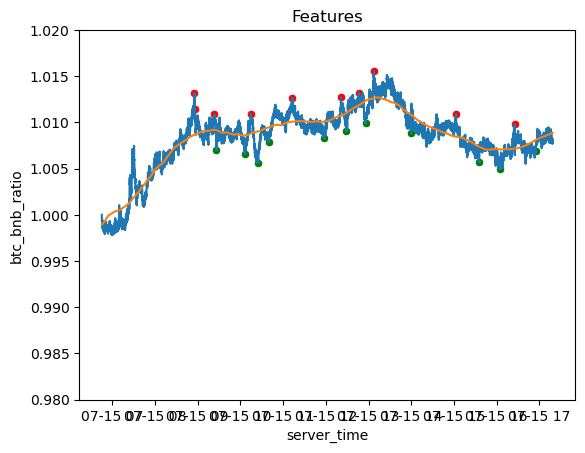

In [16]:
fig, ax = plt.subplots()
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio', ax=ax)
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
sns.lineplot(data=trend[:6000], x='server_time', y ='btc_bnb_ratio', ax=ax)
sns.lineplot(data=trend[:6000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
sns.scatterplot(data=trend[:6000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
sns.scatterplot(data=trend[:6000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
plt.title('Features')
plt.ylim([0.98, 1.02])
plt.show()

#### Устранение подряд идущих одинаковых сделок (продажа и покупка должны чередоваться)

In [17]:
columns = ['btc_bnb', 'btc_eth', 'eth_bnb']
for column in columns:


    # выделение локальных максимумов через разницу со сдвигами +- 1, обе разницы должны быть положительными
    max_price = trend[(trend[column + '_max_price'] - trend[column + '_min_price']) !=0][column + '_max_price']
    max_price_true = (max_price-max_price.shift(-1) > 0) & (max_price-max_price.shift(1) > 0)
    trend[column + '_max_price'] = (trend[column + '_max_price']*max_price_true).fillna(0)
    trend[column + '_ratio_mean_max'] = max_price_true
    trend[column + '_ratio_mean_max'] = trend[column + '_ratio_mean_max'].fillna(0).astype('int')


    # выделение локальных минимумов через разницу со сдвигами +- 1, обе разницы должны быть отрицательными.
    # предварительно 0 заменяем на 10, заведомо больше максимумов.
    min_price = trend[(trend[column + '_max_price'] - trend[column + '_min_price']) !=0][column + '_min_price']
    min_price.loc[min_price == 0] =10
    min_price_true = (min_price-min_price.shift(-1) < 0) & (min_price-min_price.shift(1) < 0)
    trend[column + '_min_price'] = (trend[column + '_min_price']*min_price_true).fillna(0)
    trend[column + '_ratio_mean_min'] = min_price_true
    trend[column + '_ratio_mean_min'] = trend[column + '_ratio_mean_min'].fillna(0).astype('int')

del max_price, max_price_true, min_price, min_price_true

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\571222238.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_price.loc[min_price == 0] =10
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\571222238.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_price.loc[min_price == 0] =10
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\571222238.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_price.loc[min_price == 0] =10


#### Перенос целей в максимумы между минимумами, и минимумы между максимами.

In [18]:
columns = ['btc_bnb', 'btc_eth', 'eth_bnb']

for column in columns:
    min_index = trend[trend[column + '_ratio_mean_min'] == 1].index
    trend[column + '_ratio_mean_max'] = 0
    index_previus = trend[:].index[0]
    
    for index in min_index:
        temp = trend.loc[index_previus:index][column + '_ratio']
        max_index = temp[temp == temp.max()].index
        trend[column + '_ratio_mean_max'].loc[max_index] = 1
        index_previus = index
    
    max_index = trend[trend[column + '_ratio_mean_max'] == 1].index
    trend[column + '_ratio_mean_min'] = 0
    index_previus = trend[:].index[0]
    
    for index in max_index:
        temp = trend.loc[index_previus:index][column + '_ratio']
        min_index = temp[temp == temp.min()].index
        trend[column + '_ratio_mean_min'].loc[min_index] = 1
        index_previus = index    

C:\Users\denis\AppData\Local\Temp\ipykernel_5392\1742788990.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend[column + '_ratio_mean_max'].loc[max_index] = 1
C:\Users\denis\AppData\Local\Temp\ipykernel_5392\1742788990.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend[column + '_ratio_mean_min'].loc[min_index] = 1


#### График

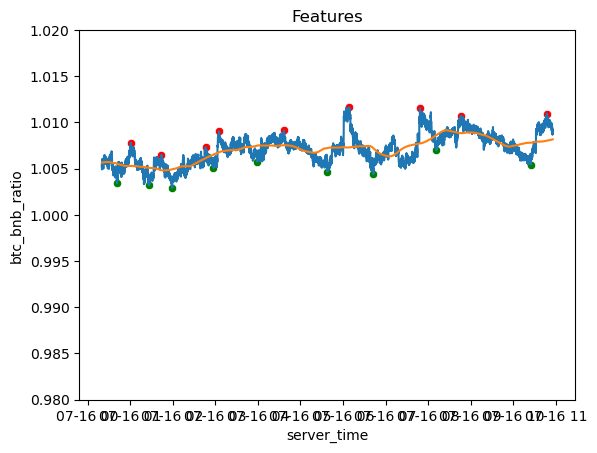

In [19]:
fig, ax = plt.subplots()
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio', ax=ax)
# sns.lineplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
# sns.scatterplot(data=trend[48000:50000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
sns.lineplot(data=trend[10000:16000], x='server_time', y ='btc_bnb_ratio', ax=ax)
sns.lineplot(data=trend[10000:16000], x='server_time', y ='btc_bnb_ratio_mean', ax=ax)
sns.scatterplot(data=trend[10000:16000], x='server_time', y ='btc_bnb_min_price', ax=ax, color='green')
sns.scatterplot(data=trend[10000:16000], x='server_time', y ='btc_bnb_max_price', ax=ax, color='red')
plt.title('Features')
plt.ylim([0.98, 1.02])
plt.show()

In [32]:
trend['btc_bnb_ratio_mean_min_max'] = trend['btc_bnb_ratio_mean_min']* -1 + trend['btc_bnb_ratio_mean_max']

<AxesSubplot:xlabel='server_time', ylabel='btc_bnb_ratio'>

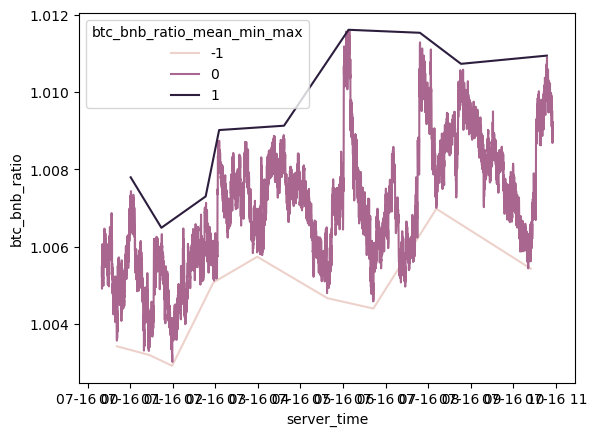

In [33]:
sns.lineplot(data=trend[10000:16000], x='server_time', y='btc_bnb_ratio', hue="btc_bnb_ratio_mean_min_max")

In [20]:
trend

,BTC/USTD,ETH/USTD,BNB/USTD,numeric_index,BTC/BNB,BTC/ETH,ETH/BNB,BTC/ETH_delta,BTC/BNB_delta,ETH/BNB_delta,btc_bnb_ratio,btc_eth_ratio,eth_bnb_ratio,btc_bnb_ratio_mean,btc_eth_ratio_mean,eth_bnb_ratio_mean,btc_eth_ratio_mean_delta,btc_bnb_ratio_mean_delta,eth_bnb_ratio_mean_delta,btc_eth_ratio_mean_min,btc_eth_ratio_mean_max,btc_bnb_ratio_mean_min,btc_bnb_ratio_mean_max,eth_bnb_ratio_mean_min,eth_bnb_ratio_mean_max,btc_bnb_deal,btc_bnb_profit,btc_eth_deal,btc_eth_profit,eth_bnb_deal,eth_bnb_profit,duble_buy,profit_max,btc_bnb_min_price,btc_bnb_max_price,btc_eth_min_price,btc_eth_max_price,eth_bnb_min_price,eth_bnb_max_price
server_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-07-15 06:45:17,20631.89,1200.75,237.7,0,86.798023,17.182503,5.051536,NaN,NaN,NaN,1.000000,1.000000,1.000000,0.998951,1.000833,0.998121,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-15 06:45:23,20627.07,1200.54,237.8,1,86.741253,17.181493,5.048528,-0.001009,-0.056770,-0.003007,0.999346,0.999941,0.999405,0.998954,1.000823,0.998135,-0.000010,0.000003,0.000013,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-15 06:45:29,20629.95,1200.74,237.8,2,86.753364,17.181030,5.049369,-0.000463,0.012111,0.000841,0.999485,0.999914,0.999571,0.998958,1.000813,0.998148,-0.000010,0.000004,0.000014,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-15 06:45:35,20625.63,1200.35,237.8,3,86.735198,17.183013,5.047729,0.001983,-0.018167,-0.001640,0.999276,1.000030,0.999246,0.998961,1.000804,0.998161,-0.000009,0.000003,0.000012,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-15 06:45:41,20631.33,1200.74,237.8,4,86.759167,17.182179,5.049369,-0.000834,0.023970,0.001640,0.999552,0.999981,0.999571,0.998966,1.000795,0.998174,-0.000009,0.000004,0.000013,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-20 21:57:30,23606.54,1544.40,262.3,76760,89.998246,15.285250,5.887915,0.005592,0.038536,0.000367,1.036870,0.889582,1.165569,1.034696,0.888249,1.164879,-0.000001,0.000007,0.000010,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-20 21:57:36,23597.97,1544.02,262.3,76761,89.965574,15.283461,5.886466,-0.001789,-0.032673,-0.001449,1.036493,0.889478,1.165282,1.034706,0.888247,1.164892,-0.000002,0.000009,0.000013,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-20 21:57:42,23591.90,1543.68,262.4,76762,89.908155,15.282895,5.882927,-0.000566,-0.057418,-0.003539,1.035832,0.889445,1.164582,1.034712,0.888245,1.164902,-0.000002,0.000006,0.000010,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0


### not_buy

In [134]:
trend['not_buy'] = ((trend['btc_bnb_ratio_mean_min']+
                     trend['btc_bnb_ratio_mean_max']+
                     trend['btc_eth_ratio_mean_min']+
                     trend['btc_eth_ratio_mean_max']+
                     trend['eth_bnb_ratio_mean_min']+
                     trend['eth_bnb_ratio_mean_max']) == 0).astype('int')

### Обрезка датафрейма с верху и низу на PERIOD

In [135]:
trend = trend.iloc[PERIOD+1:-PERIOD-1]

In [136]:
trend.shape

(76163, 40)

### Распределение классов

In [137]:
trend[['btc_bnb_ratio_mean_min',
       'btc_bnb_ratio_mean_max',
       'btc_eth_ratio_mean_min',
       'btc_eth_ratio_mean_max',
       'eth_bnb_ratio_mean_min',
       'eth_bnb_ratio_mean_max',
       'not_buy']].sum()*100/trend.shape[0]

btc_bnb_ratio_mean_min     0.147053
btc_bnb_ratio_mean_max     0.148366
btc_eth_ratio_mean_min     0.106351
btc_eth_ratio_mean_max     0.106351
eth_bnb_ratio_mean_min     0.118168
eth_bnb_ratio_mean_max     0.116855
not_buy                   99.301498
dtype: float64

In [138]:
trend.shape

(76163, 40)

## Создание признаков методом отжига?

## PyTorch

### Выделение признаков

#### Признаковое поле (trend - trend.mean) / trend.std

In [24]:
X2_temp = trend[['BTC/BNB','BTC/ETH','ETH/BNB']]

In [25]:
X2_temp.shape

(76163, 3)

In [26]:
# нулевая подложка
# X2 = np.empty([76542, 3, 224])
X2 = np.zeros((1,3,FEATURES_LENGHT))

for i in tqdm(range(FEATURES_LENGHT, X2_temp.shape[0])):
#     X2_trend = torch.from_numpy(X2_temp.iloc[i-FEATURES_LENGHT+1:i+1].values)
    X2_trend = X2_temp.iloc[i-FEATURES_LENGHT+1:i+1].values
    
    X2_trend = (X2_trend - X2_trend.T.mean(axis=1))/X2_trend.T.std(axis=1)
    X2_trend = X2_trend.T
    X2_trend = np.expand_dims(X2_trend, axis=0)
    X2 = np.append(X2, X2_trend, axis=0)
    
# удаление нулевой подложки np.zeros
X2 = X2[1:]   

 25%|███████████████████▎                                                        | 19030/74723 [15:38<45:45, 20.29it/s]


KeyboardInterrupt: 

In [ ]:
X2.shape

In [ ]:
np.save('binance_features/nparray2', X2, allow_pickle=True, fix_imports=True)

#### Признаковое поле delta / (delta.max - delta.min)

In [ ]:
X = X2

#### Целевая функция

y

- not_buy - 0
- btc_bnb_ratio_mean_min - 1	
- btc_bnb_ratio_mean_max - 2	
- btc_eth_ratio_mean_min - 3
- btc_eth_ratio_mean_max - 4	
- eth_bnb_ratio_mean_min - 5	
- eth_bnb_ratio_mean_max - 6

In [ ]:
Y = trend[['btc_bnb_ratio_mean_min','btc_bnb_ratio_mean_max','btc_eth_ratio_mean_min','btc_eth_ratio_mean_max','eth_bnb_ratio_mean_min','eth_bnb_ratio_mean_max','not_buy']]

Y=Y.rename(
    columns={
        'not_buy':'0',
        'btc_bnb_ratio_mean_min':'1',
        'btc_bnb_ratio_mean_max':'2',
        'btc_eth_ratio_mean_min':'3',
        'btc_eth_ratio_mean_max':'4',
        'eth_bnb_ratio_mean_min':'5',
        'eth_bnb_ratio_mean_max':'6'        
    }
)

y = Y.idxmax(axis=1)[FEATURES_LENGHT:]

In [ ]:
print(X.shape, y.shape)

##### Устранение дисбаланса целевой функции

In [ ]:
values, counts = np.unique(y, return_counts=True)
print(values, counts)

In [ ]:
i, = np.where(y == '1')
X_1 = X[i]
y_1 = y[i]
i, = np.where(y == '2')
X_2 = X[i]
y_2 = y[i]
i, = np.where(y == '3')
X_3 = X[i]
y_3 = y[i]
i, = np.where(y == '4')
X_4 = X[i]
y_4 = y[i]
i, = np.where(y == '5')
X_5 = X[i]
y_5 = y[i]
i, = np.where(y == '6')
X_6 = X[i]
y_6 = y[i]

In [ ]:
for i in tqdm(range(100)):
    X = np.concatenate((X, X_1, X_2, X_3, X_4, X_5, X_6), axis=0)
    y = np.concatenate((y, y_1, y_2, y_3, y_4, y_5, y_6), axis=0)

In [ ]:
values, counts = np.unique(y, return_counts=True)
print(values, counts)

In [ ]:
print(X.shape, y.shape)

In [ ]:
print(f'X memory usage {(X.nbytes/1_000_000_000):.1f} GB')

#### Перемешивание признаков и создание выборк

In [ ]:
for i in range (10):
    X, y = shuffle(X, y, random_state=RANDOM*i)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.025, random_state=RANDOM, shuffle=True)

### Загрузчики данных

In [ ]:
X_tensor = torch.tensor(X_train.astype('float32'))
y_tensor = torch.tensor(y_train.astype('int')).type(torch.LongTensor)
X_valid_tensor = torch.tensor(X_valid.astype('float32'))
y_valid_tensor = torch.tensor(y_valid.astype('int')).type(torch.LongTensor)

train = data_utils.TensorDataset(X_tensor, y_tensor)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
X_valid_tensor.shape

In [ ]:

X_valid_tensor = X_valid_tensor.to('cuda')
y_valid_tensor = y_valid_tensor.to('cuda')
print(X_valid_tensor.shape, y_valid_tensor.shape)

### Модель 1

#### Конструктор модели 1

In [ ]:
class Net_1(nn.Module):
    def __init__(self):
        super(Net_1,self).__init__()
        self.conv1 = nn.Conv1d(3, 6, 3)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(6, 12, 2)
        self.fc1 = nn.Linear(660, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [ ]:
net_1 = Net_1().to('cuda')

#### Обучение модели 1

In [ ]:
%%time

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_1.parameters(), lr=0.0001)

for epoch in range(EPOCH):
    loss_array = np.array([], dtype=float)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, y_batch = batch
        X_batch = X_batch.to('cuda')
        y_batch = y_batch.to('cuda')
        output = net_1.forward(X_batch)
#         print(output, output.shape, output.type())
#         print(y_batch, y_batch.shape, y_batch.type())
        loss =loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
    if epoch % 2 == 0:
        predict = torch.argmax(net_1.inference(X_valid_tensor), dim=1)
        good = (predict == y_valid_tensor).sum()
        accuracy = good/y_valid_tensor.shape[0]
        print(f'Epoch: {epoch}, loss: {loss_array.mean():.3f}, accuracy: {accuracy:.3f}')

In [ ]:
predict = torch.argmax(net_1.inference(X_valid_tensor), dim=1)
good = (predict == y_valid_tensor).sum()
accuracy = good/y_valid_tensor.shape[0]
print(accuracy)

### Модель 2

#### Конструктор модели 2

In [ ]:
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2,self).__init__()
        self.conv1 = nn.Conv1d(3, 9, 3, stride=1, padding=2, padding_mode='replicate')
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(9, 18, 2, stride=1, padding=2, padding_mode='replicate')
        self.fc1 = nn.Linear(468, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

In [ ]:
net_2 = Net_2().to('cuda')

#### Обучение модели 2

In [ ]:
%%time

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_2.parameters(), lr=0.0001)

for epoch in range(EPOCH):
    loss_array = np.array([], dtype=float)
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        X_batch, y_batch = batch
        X_batch = X_batch.to('cuda')
        y_batch = y_batch.to('cuda')
        output = net_2.forward(X_batch)
#         print(output, output.shape, output.type())
#         print(y_batch, y_batch.shape, y_batch.type())
        loss =loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        loss_array = np.append(loss_array, loss.to('cpu').detach().numpy())
    if epoch % 2 == 0:
        predict = torch.argmax(net_2.inference(X_valid_tensor), dim=1)
        good = (predict == y_valid_tensor).sum()
        accuracy = good/y_valid_tensor.shape[0]
        print(f'Epoch: {epoch}, loss: {loss_array.mean():.3f}, accuracy: {accuracy:.3f}')

In [ ]:
predict = torch.argmax(net_2.inference(X_valid_tensor), dim=1)
good = (predict == y_valid_tensor).sum()
accuracy = good/y_valid_tensor.shape[0]
print(accuracy)

## Проверка модели при продаже на тестовых данных

In [ ]:
trend_test = pd.read_csv('binance_features/BTC_ETH_BNB_train_7.csv', sep=';', names=['BTC/USTD','ETH/USTD','BNB/USTD', 'server_time'])
trend_test['server_time'] = trend_test['server_time'].apply(lambda x: datetime.utcfromtimestamp(int(str(x)[:10])).strftime('%Y-%m-%d %H:%M:%S'))
trend_test['server_time'] = pd.to_datetime(trend_test['server_time'])
trend_test = trend_test.set_index('server_time')
trend_test = trend_test[102:]

In [ ]:
trend_test['BTC/BNB'] = trend_test['BTC/USTD']/trend_test['BNB/USTD']
trend_test['BTC/ETH'] = trend_test['BTC/USTD']/trend_test['ETH/USTD']
trend_test['ETH/BNB'] = trend_test['ETH/USTD']/trend_test['BNB/USTD']

### Проверка модели 1

`coin_byu` - словарь для валюты:
 - `name` - название валюты,
 - `quantity` - количество на счёте,
 - `price_usdt` - текущая цена в долларах.
 
`trade_result` - DataFrame статистики по торгам:
 - `server_time` - время сервера,
 - `btc_in_usdt` - количество BTC  в колшельке определённое в долларах,
 - `bnb_in_usdt` - количество BNB  в колшельке определённое в долларах,
 - `eth_in_usdt` - количество ETH  в колшельке определённое в долларах,
 - `fee_usdt` - размер комиссии со сделки определённой в долларах,
 - `predict` - предсказание по сделке (0, 1, 2, 3, 4, 5, 6)
 - `predict_proba` - вероятность предсказания по сделке,
 - `price` - стоимость в паре (валюта покупки/ валюта продажи),
 - `profit_function` - прибыль со сделки в долларах вычесленная в функции,
 - `quantity_in_usdt` - размер кошелька в долларах,
 - `profit_in_usdt` - прибыль со сделки в долларах вычесленная как разность размера кошелька после сделки и до сделки,
 - `BTC/USTD` - стоимость в паре,
 - `trade` - выполнена сделка  (0, 1, 2, 3, 4, 5, 6).

Функция выполнения сделки.

In [ ]:
# coin_buy = {'name': 'BTC','quantity': 21, 'price_usdt': 19275, 'last_trade': {'operation':'buy', 'coin':'ETH', price:'737'}}

def buy(coin_buy, coin_sell, price, proba):
    
    all_coin_in_usdt_before = coin_buy['quantity']*coin_buy['price_usdt'] + coin_sell['quantity']*coin_sell['price_usdt']
    
    coin_sell_part = proba * np.clip((coin_sell['quantity']*coin_sell['price_usdt'])
                                        /(coin_buy['quantity']*coin_buy['price_usdt']), 0, 0.1) * coin_sell['quantity']
    coin_buy_part = coin_sell_part / price
    fee = FEE * coin_buy_part
    coin_sell_out = coin_sell['quantity'] - coin_sell_part
    coin_buy_out = coin_buy['quantity'] + coin_buy_part - fee
    
    all_coin_in_usdt_after = coin_buy_out*coin_buy['price_usdt'] + coin_sell_out*coin_sell['price_usdt']
    profit = all_coin_in_usdt_after - all_coin_in_usdt_before
    
    # условие для совершения сделки
    # 1) таже пара торгуется по цене если есть прибыль относительно комиссии,
    # 2) другая пара,
    # 3) другая сделка (не покупка)
    
#     if ((coin_buy['last_trade']['operation'] == 'buy') and
#         (coin_buy['last_trade']['coin'] == coin_sell['name']) and
#         (coin_buy['last_trade']['price']-price > fee*5)) or (coin_buy['last_trade']['operation'] == 'sell') or (coin_buy['last_trade']['coin'] != coin_sell['name']):
    if True:   

        coin_buy['last_trade']['operation'] = 'buy'
        coin_buy['last_trade']['coin'] = coin_sell['name']
        coin_buy['last_trade']['price'] = price
        coin_sell['last_trade']['operation'] = 'sell'
        
        status = 1
    else:
        coin_buy_out = coin_buy['quantity']
        coin_sell_out = coin_sell['quantity']
        status = 0
        profit = 0
        fee = 0
    return coin_buy_out, coin_sell_out, fee*coin_buy['price_usdt'], profit, status
    


Функция проверки баланса в кошелке.
 - На входе словари валют кошелька. 
 - На выходе состояние: 0 - пропорции в норме, 1 - нужно покупать BTC, 2 - нужно покупать BNB, 3 - нужно покупать ETH.

In [ ]:
def check_proportion(btc, bnb, eth):
    limit = 0.2 # допустимый минимум доли валюты в кошельке
    coin_quantity_in_usdt = pd.Series(data=[btc['quantity']*btc['price_usdt'],
                                             bnb['quantity']*bnb['price_usdt'],
                                             eth['quantity']*eth['price_usdt']],
                                      index=[1, 2, 3]).sort_values()
    limit_quantity_in_usdt = coin_quantity_in_usdt.sum() * limit
    
    if coin_quantity_in_usdt.values[0] > limit_quantity_in_usdt:
        flag = 0
    else:
        flag = coin_quantity_in_usdt.index[0]    
    
    return 0 # 0- пропорции в норме, 1 - нужно покупать BTC, 2 - нужно покупать BNB, 3 - нужно покупать ETH

Поток данных организую в цикле, каждый цикл - имитация считывания в интервале 5 сек с сервака.

In [ ]:
btc = {'name': 'BTC', 'quantity': 100/19275, 'price_usdt': 19275, 'last_trade': {'operation':'sell', 'coin':'ETH', 'price':0}}
bnb = {'name': 'BNB', 'quantity': 100/275, 'price_usdt': 275, 'last_trade': {'operation':'sell', 'coin':'ETH', 'price':0}}
eth = {'name': 'ETH', 'quantity': 100/1306, 'price_usdt': 1306, 'last_trade': {'operation':'sell', 'coin':'ETH', 'price':0}}

btc_in_usdt = btc['quantity']*btc['price_usdt']
bnb_in_usdt = bnb['quantity']*bnb['price_usdt']
eth_in_usdt = eth['quantity']*eth['price_usdt']

time = trend_test.index[FEATURES_LENGHT-1]
columns_result = ['server_time','btc_in_usdt', 'bnb_in_usdt', 'eth_in_usdt', 'fee_usdt', 'predict', 'predict_proba', 'price', 'profit_function', 'trade']
data = dict(zip(columns_result,[[time],[btc_in_usdt], [bnb_in_usdt], [eth_in_usdt], [0], [0], [0], [0], [0], [0]]))
trade_result = pd.DataFrame(data)

features_step = np.expand_dims(trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[0].values, axis=0)
predicts = np.zeros(0)
predicts_proba = np.zeros(0)


net_1 = net_1.to('cpu')

for step in tqdm(trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[1:].iterrows()):
    time = step[0]
    step = step[1:][0]
    step_exp = np.expand_dims(step, axis=0)
    features_step = np.append(features_step, step_exp, axis=0)
    feattures_step_transp = features_step[-FEATURES_LENGHT:].T
    
    # условие достаточного количества признаков для предсказания
    if feattures_step_transp.shape[1] == FEATURES_LENGHT:

        features = ((feattures_step_transp.T - feattures_step_transp.mean(axis=1))/feattures_step_transp.std(axis=1)).T
        features = np.expand_dims(features, axis=0)
        features = torch.tensor(features.astype('float32'))
        predict_proba = net_1.inference(features)
        predict = torch.argmax(predict_proba, dim=1).detach().item()
        predict_proba = predict_proba.max().detach().item()
        
        # проверка пропорции валют в кошельке
        check_proportion_result = check_proportion(btc, bnb, eth)
        
#         print('----------------------------------------------------')
#         print('check_proportion_result',check_proportion_result)
#         print('btc', btc['quantity']*btc['price_usdt'])
#         print('bnb', bnb['quantity']*bnb['price_usdt'])
#         print('eth', eth['quantity']*eth['price_usdt'])
        
        
        # действия с валютой
        if predict == 0:
            fee_usdt = 0
            price = 0
            profit = 0
            status = 0
        
        # 0- пропорции в норме, 1 - нужно покупать BTC, 2 - нужно покупать BNB, 3 - нужно покупать ETH
        
        if predict == 1 and check_proportion_result in [0, 1]: # btc_bnb_buy
            price = step[0]
            btc['quantity'], bnb['quantity'], fee_usdt, profit, status = buy(btc, bnb, price, predict_proba)
#             print('btc_bnb_buy')
            
        if predict == 2  and check_proportion_result in [0, 2]: # btc_bnb_sell
            price = 1/step[0]
            bnb['quantity'], btc['quantity'], fee_usdt, profit, status = buy(bnb, btc, price, predict_proba) 
#             print('btc_bnb_sell')
            
        if predict == 3 and check_proportion_result in [0, 1]: # btc_eth_buy
            price = step[1]
            btc['quantity'], eth['quantity'], fee_usdt, profit, status = buy(btc, eth, price, predict_proba)
#             print('btc_eth_buy')
            
        if predict == 4  and check_proportion_result in [0, 3]: # btc_eth_sell
            price = 1/step[1]
            eth['quantity'], btc['quantity'], fee_usdt, profit, status = buy(eth, btc, price, predict_proba)
#             print('btc_eth_sell')
            
        if predict == 5  and check_proportion_result in [0, 3]: # eth_bnb_buy
            price = step[2]
            eth['quantity'], bnb['quantity'], fee_usdt, profit, status = buy(eth, bnb, price, predict_proba)
#             print('eth_bnb_buy')
            
        if predict == 6  and check_proportion_result in [0, 2]: # eth_bnb_sell
            price = 1/step[2]
            bnb['quantity'], eth['quantity'], fee_usdt, profit, status = buy(bnb, eth, price, predict_proba)
#             print('eth_bnb_sell')
        
        btc_in_usdt = btc['quantity']*btc['price_usdt']
        bnb_in_usdt = bnb['quantity']*bnb['price_usdt']
        eth_in_usdt = eth['quantity']*eth['price_usdt']
        
        data = dict(zip(columns_result,[[time],[btc_in_usdt], [bnb_in_usdt], [eth_in_usdt], [fee_usdt], [predict], [predict_proba], [price], [profit], [status*predict]]))
        current_result = pd.DataFrame(data)
        trade_result = pd.concat([trade_result, current_result])     

trade_result = trade_result[1:].set_index('server_time')

In [ ]:
trade_result = pd.merge(trade_result, trend_test, on='server_time')
trade_result['quantity_in_usdt'] = trade_result[['btc_in_usdt','bnb_in_usdt','eth_in_usdt']].sum(axis=1)
trade_result['profit_in_usdt'] = trade_result['quantity_in_usdt'] - trade_result['quantity_in_usdt'].shift(1) 

#### Общие статистики после торгов

In [ ]:
print('Usdt after trade :', trade_result['quantity_in_usdt'][-1])
print('Sum all fee in usdt:', trade_result['fee_usdt'].sum())
print('Sum all profit in usdt > 0:', trade_result[trade_result['profit_in_usdt'] > 0]['profit_in_usdt'].sum())
print('Sum all profit in usdt <= 0:', trade_result[trade_result['profit_in_usdt'] <= 0]['profit_in_usdt'].sum())

#### Изменение объёма валют в кошельке

In [ ]:
trade_result[trade_result['predict'] == 3]

In [ ]:
print(f'Распределение валют после торгов в USDT:\n',
      f'BTC - {trade_result["btc_in_usdt"][-1]:.4f}\n BNB - {trade_result["bnb_in_usdt"][-1]:.4f}\n ETH - {trade_result["eth_in_usdt"][-1]:.4f}\n')

In [ ]:
columns = ['btc_in_usdt','bnb_in_usdt','eth_in_usdt']

for column in columns:
    sns.lineplot(data=trade_result, x="server_time", y=column)
    plt.title('Изменение объёма ' + column)
    plt.show()

In [ ]:
sns.lineplot(data=trade_result, x="server_time", y="quantity_in_usdt")
plt.title('Изменение объёма кошельлка в долларах')
plt.show()

#### Распределение операций за время торгов

In [ ]:
trade_result.groupby('predict')['price'].count()

In [ ]:
trade_result.groupby('trade')['price'].count()

In [ ]:
interval_cols = trade_result.columns
phik_overview = pd.DataFrame(trade_result, columns=interval_cols).phik_matrix(interval_cols=interval_cols)


plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 10))
plt.tight_layout()

In [ ]:
sns.lineplot(data=trade_result, x="server_time", y="profit_in_usdt")

In [ ]:
sns.lineplot(data=trade_result, x="server_time", y="fee_usdt")

In [ ]:
sns.histplot(data=trade_result[abs(trade_result['profit_in_usdt']) > 0.001], x="profit_in_usdt", bins = 1000)

#### Продажи на тренде.

In [ ]:
trade_result['BTC/BNB_buy_price'] = trade_result['BTC/BNB']*(trade_result['trade'] == 1)
trade_result['BTC/BNB_sell_price'] = trade_result['BTC/BNB']*(trade_result['trade'] == 2)
trade_result['BTC/ETH_buy_price'] = trade_result['BTC/ETH']*(trade_result['trade'] == 3)
trade_result['BTC/ETH_sell_price'] = trade_result['BTC/ETH']*(trade_result['trade'] == 4)
trade_result['ETH/BNB_buy_price'] = trade_result['ETH/BNB']*(trade_result['trade'] == 5)
trade_result['ETH/BNB_sell_price'] = trade_result['ETH/BNB']*(trade_result['trade'] == 6)

In [ ]:
range_trade_begin = 21_000
range_trade_end = 21_500
columns = ['BTC/BNB','BTC/ETH','ETH/BNB']

for column in columns:
    fig, ax = plt.subplots()
    sns.lineplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column, ax=ax)
    sns.scatterplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column + '_buy_price', ax=ax, color='green')
    sns.scatterplot(data=trade_result[range_trade_begin:range_trade_end], x='server_time', y =column + '_sell_price', ax=ax, color='red')
    plt.title(column + ' buy sell')
    plt.ylim([trade_result[column][range_trade_begin:range_trade_end].min(), trade_result[column][range_trade_begin:range_trade_end].max()])
    plt.show()

### Проверка модели 2

Поток данных организую в цикле, каждый цикл - имитация считывания в интервале 5 сек с сервака.

In [ ]:
btc = 100/19275
bnb = 100/275
eth = 100/1306
usdt = np.array([btc*19275+bnb*275+eth*1306])
not_buy = 0
btc_bnb_buy = 0
btc_bnb_sell = 0
btc_eth_buy = 0
btc_eth_sell = 0
eth_bnb_buy = 0
eth_bnb_sell = 0

fee = FEE

net_2 = net_2.to('cpu')

step_prev = trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[0]
features_delta = np.zeros((1,3))
predicts = np.zeros(1)

print(f'USDT before traid: {usdt[0]}')

for step in tqdm(trend_test[['BTC/BNB','BTC/ETH','ETH/BNB']].iloc[1:].iterrows()):
    step = step[1:][0]
    delta = step - step_prev
    delta_exp = np.expand_dims(delta, axis=0)
    features_delta = np.append(features_delta, delta_exp, axis=0)
    feattures_delta_transp = features_delta[-FEATURES_LENGHT:].T
    step_prev = step
    
    # условие достаточного количества признаков для предсказания
    if feattures_delta_transp.shape[1] == FEATURES_LENGHT:
        max_min = feattures_delta_transp.max(axis=1) - feattures_delta_transp.min(axis=1)
        features = np.divide(feattures_delta_transp.T, max_min).T
        features = np.expand_dims(features, axis=0)
        features = torch.tensor(features.astype('float32'))
#        features = features.to('cuda')
        predict_proba = net_1.inference(features)
        predict = torch.argmax(predict_proba, dim=1)
#         predicts = np.append(predicts, predict.to('cpu'), axis=0)
#         predict_proba = predict_proba.to('cpu')
        predicts = np.append(predicts, predict, axis=0)
        
        # действия с валютой
        if predict == 0:
            not_buy += 1
        elif predict == 1:
            btc_bnb_buy += 1

            bnb_sell = predict_proba.max().detach()*np.clip((bnb*275)/(btc*19275), 0, 0.6)*bnb
            bnb = bnb - bnb_sell
            btc = btc + (1-fee)*bnb_sell/step[0]
            
        elif predict == 2:
            btc_bnb_sell += 1
            
            btc_sell = predict_proba.max().detach()*np.clip((btc*19275)/(bnb*275), 0, 0.6)*btc
            btc = btc - btc_sell
            bnb = bnb + (1-fee)*btc_sell * step[0]
            
        elif predict == 3:
            btc_eth_buy += 1
            
            eth_sell = predict_proba.max().detach()*np.clip((eth*1306)/(btc*19275), 0, 0.6)*eth
            eth = eth - eth_sell
            btc = btc + (1-fee)*eth_sell/step[1]            
            
        elif predict == 4:
            btc_eth_sell += 1
            
            btc_sell = predict_proba.max().detach()*np.clip((btc*19275)/(eth*1306), 0, 0.6)*btc
            btc = btc - btc_sell
            eth = eth + (1-fee)*btc_sell * step[1]
            
        elif predict == 5:
            eth_bnb_buy += 1
            
            bnb_sell = predict_proba.max().detach()*np.clip((bnb*275)/(eth*1306), 0, 0.6)*bnb
            bnb = bnb - bnb_sell
            eth = eth + (1-fee)*bnb_sell/step[2]              
            
        elif predict == 6:
            eth_bnb_sell += 1
            
            eth_sell = predict_proba.max().detach()*np.clip((eth*1306)/(bnb*275), 0, 0.6)*eth
            eth = eth - eth_sell
            bnb = bnb + (1-fee)*eth_sell * step[2]            
            
            
        usdt = np.append(usdt, np.array([btc*19275+bnb*275+eth*1306]), axis=0)

print(f'USDT after traid: {usdt[-1]:.2f}')

In [ ]:
print(f'Распределение торговых сделок:\n',
      f'Нет сделки - {not_buy}\n btc_bnb_buy - {btc_bnb_buy}\n btc_bnb_sell - {btc_bnb_sell}\n'
      f' btc_eth_buy - {btc_eth_buy}\n btc_eth_sell - {btc_eth_sell}\n eth_bnb_buy - {eth_bnb_buy}\n eth_bnb_sell - {eth_bnb_sell}')

print(f'Распределение валют после торгов в USDT:\n',
      f'BTC - {btc*19275:.4f}\n BNB - {bnb*275:.4f}\n ETH - {eth*1306:.4f}\n')

plt.plot(usdt)
plt.grid(visible=True)
plt.show()

In [ ]:
plt.plot(trend_test['BTC/USTD'])
plt.grid(visible=True)
plt.show()